# Overview

PanGaia simplifies the access, exploration, and clustering analysis of the Gaia DR2 [catalogue](https://gea.esac.esa.int/archive/).
Its target audience is mainly the community of astromers who are *familiar* with the Gaia archive and that are interested in Star Formation.
This code closely follows the analysis described by [Canovas et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...626A..80C/abstract) to identify more than 150 potential new candidates of the $\rho$-Ophiuchus Star Forming Region using Gaia astrometry.


### **PanGaia in a Nutshell:**
1. **Data Access**: An [ADQL](http://www.ivoa.net/documents/ADQL/2.0) cone-search (e.g. [link](https://gea.esac.esa.int/archive-help/adql/examples/index.html)) in the Gaia DR2 archive is performed using the [astroquery.gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package. Several extra columns are added to the queried table (like e.g. the distance, computed as the inverse of the parallax, $d = 1/\varpi$),
which is saved as a .vot table in the current directory. 


2. **Data Exploration:** The on-sky distribution of the data is visualised using [pyESASky](https://www.cosmos.esa.int/web/esdc/pyesasky), and the [plotly](https://plot.ly/python/) Python library is used for an interactive inspection of the sky position, proper motions, and distances of the data.


3. **Clustering Analysis:** Clusters (overdensities) in the 5-dimensional space defined by the 3 Cartesian dimensions (X, Y, and Z in Galactic coordinates), and the 2 proper motions $\mu_{\alpha}^*$ and $\mu_{\delta}$) of the downloaded dataset are identified using the 
[HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) Machine Learning algorithm (an unsupervised density-based clustering algorithm). PanGaia automatically executes this algorithm for a range of *minimum Cluster Size* values. 


### **Products:**

The main products are  
1) the data sample downloaded from the Gaia archive, and  
2) the clusters identified by the HDSBCAN algorithm.

The intermediate steps of the analysis are saved as .vot tables and .pdf figures.


### **Notes:**
* PanGaia has been written in a flexible way that allows the user to tune the code. For example, the visualization and clustering parts can easily be switched-off. This is an interesting option if the user is only interested in performing a cone-search in the Gaia DR catalogue.
* Most of the functions and methods used by the code can run in an interactive way (default option, where the user is asked to input the needed parameters) or in a automatized way (examples are given accross this notebook).
* Most of the methods and functions used in this notebook contain several arguments that are not shown for the sake of simplicity. Expert python users interested in finding more about this are encouraged to take a look to the dedicated libraries saved in the "../library/" directory.

###### This notebook was written by Héctor Cánovas (hcanovas@sciops.esa.int), and is licensed under a MIT License

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1">Overview</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#PanGaia-in-a-Nutshell:" data-toc-modified-id="PanGaia-in-a-Nutshell:-1.0.1"><strong>PanGaia in a Nutshell:</strong></a></span></li><li><span><a href="#Products:" data-toc-modified-id="Products:-1.0.2"><strong>Products:</strong></a></span></li><li><span><a href="#Notes:" data-toc-modified-id="Notes:-1.0.3"><strong>Notes:</strong></a></span></li></ul></li></ul></li><li><span><a href="#Customize-Pangaia:" data-toc-modified-id="Customize-Pangaia:-2">Customize Pangaia:</a></span></li><li><span><a href="#1.--Load-Control-Sample" data-toc-modified-id="1.--Load-Control-Sample-3">1.- Load Control Sample</a></span></li><li><span><a href="#2.--Run-pyESASky" data-toc-modified-id="2.--Run-pyESASky-4">2.- Run pyESASky</a></span></li><li><span><a href="#3.--Construct-Data-Sample" data-toc-modified-id="3.--Construct-Data-Sample-5">3.- Construct Data Sample</a></span><ul class="toc-item"><li><span><a href="#3.1-Query-the-Gaia-Archive" data-toc-modified-id="3.1-Query-the-Gaia-Archive-5.1">3.1 Query the Gaia Archive</a></span></li><li><span><a href="#3.2-Load-the-dataset-to-the-Utils-package" data-toc-modified-id="3.2-Load-the-dataset-to-the-Utils-package-5.2">3.2 Load the dataset to the Utils package</a></span></li></ul></li><li><span><a href="#4.--Visual-Analysis" data-toc-modified-id="4.--Visual-Analysis-6">4.- Visual Analysis</a></span><ul class="toc-item"><li><span><a href="#4.1-Dynamic-data-exploration" data-toc-modified-id="4.1-Dynamic-data-exploration-6.1">4.1 Dynamic data exploration</a></span></li><li><span><a href="#4.2-On-Sky-distribution-exploration" data-toc-modified-id="4.2-On-Sky-distribution-exploration-6.2">4.2 On-Sky distribution exploration</a></span></li></ul></li><li><span><a href="#5.--Clustering-Analysis" data-toc-modified-id="5.--Clustering-Analysis-7">5.- Clustering Analysis</a></span><ul class="toc-item"><li><span><a href="#5.1-Preprocess-the-data" data-toc-modified-id="5.1-Preprocess-the-data-7.1">5.1 Preprocess the data</a></span></li><li><span><a href="#5.2-Apply-HDSBCAN" data-toc-modified-id="5.2-Apply-HDSBCAN-7.2">5.2 Apply HDSBCAN</a></span></li><li><span><a href="#5.3-Examine-the-HDBSCAN-outcomes" data-toc-modified-id="5.3-Examine-the-HDBSCAN-outcomes-7.3">5.3 Examine the HDBSCAN outcomes</a></span></li></ul></li><li><span><a href="#6.--Compare-to-Control-Sample" data-toc-modified-id="6.--Compare-to-Control-Sample-8">6.- Compare to Control Sample</a></span></li><li><span><a href="#Save-HDBSCAN-Output" data-toc-modified-id="Save-HDBSCAN-Output-9">Save HDBSCAN Output</a></span></li></ul></div>

In [1]:
# Python Basics ========================
import warnings, sys
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.append('../library/')

# Custom ===============================
from lib_utils       import LibUtils       as Utils
from lib_gaia_query  import LibGaiaQuery   as GaiaQuery
from lib_interactive import LibInteractive as Interactive
from lib_cluster     import LibCluster     as Cluster
from lib_plotters    import LibPlotters    as Plotters
from lib_compare     import LibCompare     as Compare

# pyESASky =============================
from pyesasky.pyesasky import ESASkyWidget

from astropy.table            import Table

# Adjust cell size =====================
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) ## Adjust cell size as you wish

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Customize Pangaia:

The notebook is structured into 4 separated blocks or steps, each of which is indepent from the others. To decide how to run PanGaia set the steps below to ```True/False```:

In [2]:
step_1 = True # Load Control Sample
step_2 = False # ESASky Plot
step_3 = False # Interactive/Dynamical Gaia Data exploration (Plotly)
step_4 = True # Clustering Analysis (HDSBCAN)

# 1.- Load Control Sample

The control sample is loaded if ```step_1 = True```. There are a number of variables that can be easily modified:
* Line  3: Set the control sample ```color``` and ```label```.
* Line  4: Set the directory from where the control samples are read. The code searches for the .vot tables stored in this directory and asks the user to choose one of them. Alternatively, the control sample can be specified as e.g., ```control.read_catalogue('../samples_control/sample_control_IC_348.vot')```
* Line  5: Set the number of control sample rows (```N_rows```) to be displayed (starting from the first row).
* Line 10: Change the features displayed in the plot & histogram by modifying the ```col_x, col_y, col_hist``` arguments.


Sample Control loaded. N_elements (rows) = 144

Checking catalogue columns (ra, dec, parallax, pmra, phot_g_mean_mag, etc) - OK

Showing Sample Control first 5 rows:


col2mass,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,l,b,visibility_periods_used,radial_velocity,unit_weight_e,ruwe,distance,phot_g_mean_mag_abs,phot_bp_mean_mag_abs,phot_rp_mean_mag_abs,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,X_gal,Y_gal,Z_gal,pm_mod
,,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,deg,deg,,km / s,,,pc,mag,mag,mag,mag,mag,mag,pc,pc,pc,
bytes16,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,int16,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64
03430679+3148204,216575791780899200,55.77832585931487,31.805676998022935,3.368292212211576,0.18569575746121944,4.153055103839073,0.24327365471569765,-7.238032874307061,0.1874717775215194,16.336063,18.711496,14.907626,627.83307,41.59013,198.40709,160.48133628908516,-18.274279107720577,9,--,1.8418794652984396,1.078421,296.8863557545719,8.973112190843308,11.348545158982956,7.544674957872116,0.0015927801,0.024044167,0.0050401427,-265.71249557733364,94.19114879201432,-93.09353047627064,8.344877865198118
03432622+3159286,216673162984386944,55.859323289998294,31.99127822034385,2.632751869978748,0.2504633438776319,4.608158705333078,0.4623583068436142,-6.940869193945712,0.2801396522260879,18.188923,20.33305,16.75615,508.76843,14.258361,157.91954,160.41233815127958,-18.08751919003965,9,--,1.1610862156055872,0.96449953,379.8307054314511,10.290972531622979,12.435099423712822,8.858198941535088,0.0019655307,0.07013429,0.006332339,-340.1660512901451,121.04514881599239,-117.92579991816214,8.331313931247678
03432774+3208314,216692099496268288,55.86564895264847,32.142068755211675,3.315366603457813,0.20983146461589036,4.584408968543563,0.43174948098974925,-7.2091046805227315,0.24425233421779075,17.565023,19.63398,16.151264,601.43933,24.294651,176.66731,160.31545184985518,-17.968026007948183,8,--,1.1918276439315283,0.94958436,301.6257686124468,10.167681214234388,12.236637589356459,8.753921982667006,0.0016626781,0.041161325,0.0056603565,-270.1482103718381,96.64487582456944,-93.04738954315665,8.543301228775526
03433205+3206172,216685949103101824,55.88362722579706,32.104790681581335,2.9996222049239414,0.05954141609718637,3.555695459980017,0.1183264543616157,-6.921575941462564,0.06722023993853171,14.828465,15.982068,13.762056,661.0584,126.30815,243.22202,160.35279023811825,-17.987003245808655,8,--,1.2506929608546613,1.0847275,333.375315850936,7.213798260914656,8.367400861012312,6.147389149891707,0.0015127256,0.007917145,0.0041114697,-298.6218375242565,106.61178748238133,-102.94671506249932,7.78146411143532
03433365+3201451,216673678380015232,55.89025861343185,32.029207864923364,3.2290728529141717,0.1792326043703605,4.7918714236640385,0.325847169733034,-7.534572612363947,0.20241032929788338,17.243881,--,--,416.147,--,--,160.40809188995905,-18.0415794082769,9,--,1.399380613109474,1.3609223,309.68641636484625,9.78927044302494,--,--,0.002402997,--,--,-277.4119577216782,98.73781033456953,-95.91207955341868,8.929267393908242


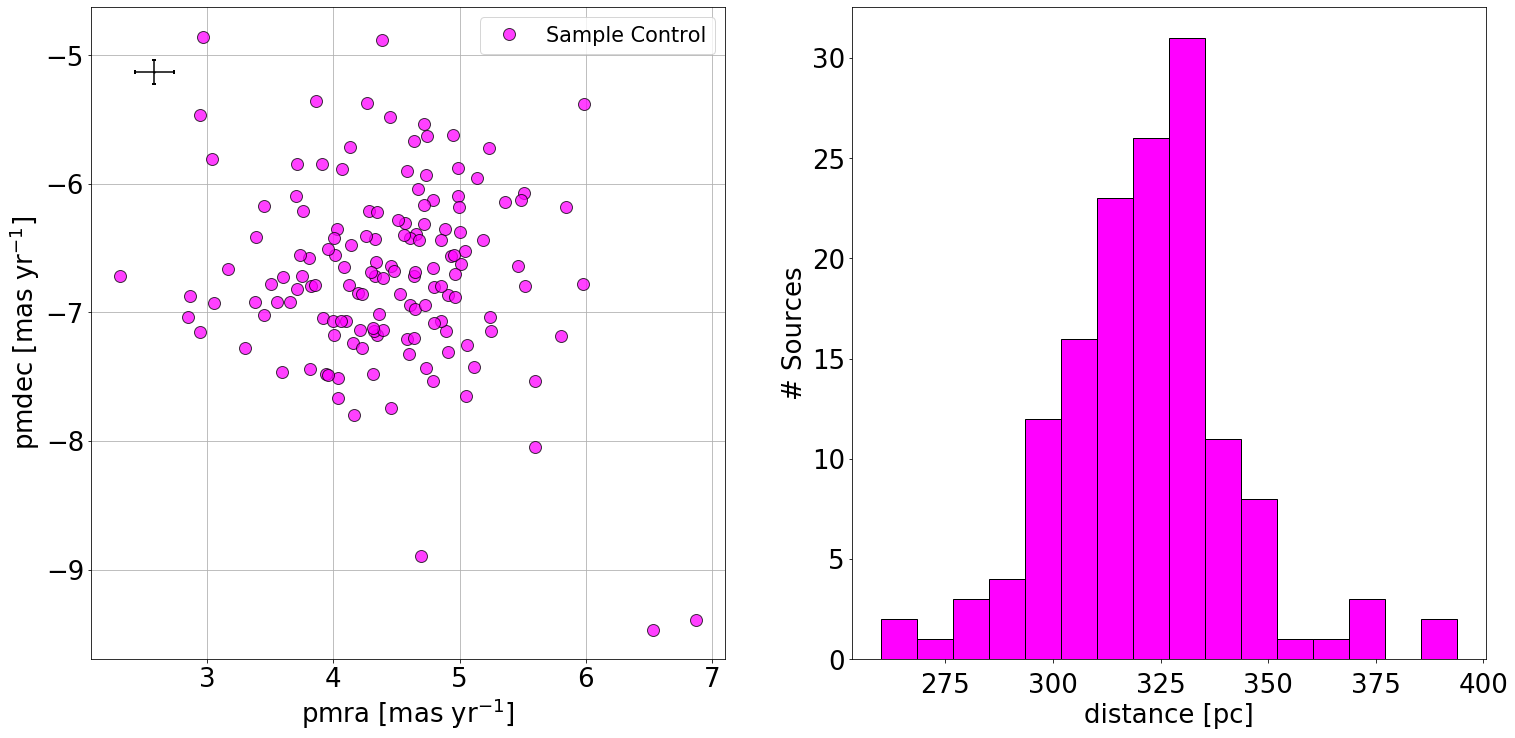

In [3]:
# Load Control Sample ==================================
if step_1:
    control = Utils(color = 'magenta', label = 'Sample Control')
    control.read_catalogue('../samples_control/sample_control_IC_348.vot') #     control.read_catalogue(sample_dir = '../samples_control/')
    control.display_N_rows(N_rows = 5, verbose = True)

    # Examine Velocity & Histograms ====================
    figures  = Plotters()
    figures.load_gaia_obj(control)
    figures.plot_2d_and_hist(col_x = 'pmra', col_y = 'pmdec', col_hist = 'distance')

# 2.- Run pyESASky
pyESASKy is a Python widget that opens an [ESASky](https://sky.esa.int/?target=273.2303166666667%2068.36347222222221&hips=DSS2%20color&fov=0.09993670884473815&cooframe=J2000&sci=true&lang=en) window locally. If 
```step_2 = True``` the widget overplots the control and/or queried sample on top of a RGB background mid-infrared image (by default). Different backgrounds and data-markers properties (e.g., symbols, colors, sizes) can be chosen using the interactive buttoms of pyESASky. A random image will be displayed if there is no control sample.

In [4]:
# Run ESASKY ===========================================
if step_2:
    esasky = ESASkyWidget()
    display(esasky)
    
    if step_1:
        figures_0  = Plotters()
        figures_0.load_gaia_obj(control)
        figures_0.send_to_ESASky(esasky)    

# 3.- Construct Data Sample

## 3.1 Query the Gaia Archive

The next cell executes an [ADQL](http://www.ivoa.net/documents/ADQL/2.0) cone-search query in the Gaia archive. If there is a Control sample, its average Right Ascension and Declination ($\overline{\alpha_{\mathrm{ctrl}}}, \overline{\delta_{\mathrm{ctrl}}}$), maximum/minimum parallax ($\varpi_{\mathrm{ctrl - min/max}}$), and its projected radius on-sky ($r_{\mathrm{ctrl}}$) will be listed. The code will first ask for a name that will be used as the rootname for all the data products created by this notebook. Afterwards PanGaia will define the central coordinates of the query. If the control sample has been loaded then its $\overline{\alpha_{\mathrm{ctrl}}}, \overline{\delta_{\mathrm{ctrl}}}$ will be automatically used to center the cone search. Otherwise, the user will have to input the $\alpha, \delta$ (in $[^{\circ}]$) of the query. The code will additionally ask for the cone-search radius ($r_\mathrm{cone}$; in $[^{\circ}]$) and for the parallax range ($\varpi_{\mathrm{cone-min/max}}$; in [mas]) to constrain the query. To obtain a sample that encompases the entire control sample the query parameters should satisfy these conditions:  
$r_\mathrm{cone} > r_\mathrm{ctrl}$,  
$\varpi_\mathrm{cone-max} > \varpi_\mathrm{ctrl-max}$, and  
$\varpi_\mathrm{cone-min} < \varpi_\mathrm{ctrl-min}$.

The query can be authomatised by changing line 5 or 8 below including the necessary arguments as e.g., 

```sample_queried.set_cone_search_pars(sample_name = 'test', ra = 56.1, dec = 32.2, radii = 1.25, para_m = 2.4, para_M = 4.1)```

Additionally, PanGaia includes three quality constraints that can be easily adjusted in line 11 below:

```sample_queried.run_cone_search(quality_par_SN  = '10', quality_par_vis = '7',quality_par_ruwe = '1.40')```

The first argument of this method sets the minimum signal to noise (S/N) of the parallax of the sources downloaded. The second argument sets the minimum amount of [visibility periods](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html) used to compute the astrometric solution for each source, and the third argument sets the maximun value of the [RUWE](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_ruwe.html) parameter.

Once the coordinates and constraints are set the code executes the ADQL query using the [astroquery.gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, downloading a .vot table with the query output to the current directory. Information regarding the query, its status, and the general properties of the downloaded sample are displayed.

In [5]:
# Set Cone-search query parameters and constraints =====
sample_queried = GaiaQuery()
if step_1:
    control.print_cone_properties()
#     sample_queried.set_cone_search_pars(ra = control.ADQL['ra'].value, dec = control.ADQL['dec'].value)
    sample_queried.set_cone_search_pars(sample_name = 'test', ra = 56.1, dec = 32.2, radii = 0.5, para_m = 2.4,para_M = 4.1)
else:
    sample_queried.set_cone_search_pars()


# Execute cone-search query and download data ==========
sample_queried.run_cone_search(quality_par_SN  = '10.0', quality_par_vis = '7.0', quality_par_ruwe = '1.40')

Sample Control on-Sky sample properties:
* Average R.A.         56.12, deg
* Average Dec.         32.16, deg
* Radius on-sky         0.30, deg
* Parallax min          2.51, mas
* Parallax max          3.92, mas

RUNNING ADQL ASYNCRHRONOUS QUERY =========================================================
Launched query: 'SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, gaia.phot_g_mean_flux_over_error, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.l, gaia.b, gaia.visibility_periods_used, gaia.radial_velocity ,sqrt(gaia.astrometric_chi2_al/(gaia.astrometric_n_good_obs_al-5)) as unit_weight_e, g_ruwe.ruwe as ruwe FROM gaiadr2.gaia_source as gaia LEFT OUTER JOIN gaiadr2.ruwe  AS g_ruwe ON gaia.source_id = g_ruwe.source_id WHERE 1=CONTAINS( POINT('ICRS',ra,dec), CIRCLE('ICRS',56.10, 32.20,  0.50)) AND parallax >

## 3.2 Load the dataset to the Utils package
Once the query is finished the user can set the color and label associated to this dataset by modifying the ```color``` and ```label``` arguments set in line 2. By defaul, the label is the name set at the beggining of the query and the color is set to grey (except for visualisation with pyESASky, where this sample is represented as white squares by default as indicated in line 11).

In [6]:
# Load data sample for analysis ======================== 
sample_gaia = Utils(color = 'grey', label = sample_queried.sample_name)
sample_gaia.read_catalogue(sample_queried.cat, save_sample = True, print_vrad = True)
sample_gaia.display_N_rows(N_rows = 5, verbose = True)


# Show output in ESASky ================================
if step_2:
    figures  = Plotters()
    figures.load_gaia_obj(sample_gaia)
    figures.send_to_ESASky(esasky, color= 'white', radius = sample_gaia.ADQL['radii'].value)

test loaded. N_elements (rows) = 291

Checking catalogue columns (ra, dec, parallax, pmra, phot_g_mean_mag, etc) - OK
Adding new column to Gaia DR2 dataset: Distance
Adding new columns to Gaia DR2 dataset: Absolute Magnitudes
Adding new columns to Gaia DR2 dataset: Magnitude Errors
Adding new columns to Gaia DR2 dataset: Galactic Spatial Coordinates (X, Y, Z)_Gal
Adding new columns to Gaia DR2 dataset: Proper Motion Modulus

vrad measurements for 17 sources ( 5.8% of the sample)
vrad =              15.8 +/- 19.9 [km / s]

Saving test as: test.vot

Showing test first 5 rows:


source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,l,b,visibility_periods_used,radial_velocity,unit_weight_e,ruwe,distance,phot_g_mean_mag_abs,phot_bp_mean_mag_abs,phot_rp_mean_mag_abs,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,X_gal,Y_gal,Z_gal,pm_mod
,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,,,,deg,deg,,km / s,,,pc,mag,mag,mag,mag,mag,mag,pc,pc,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,int16,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64
216661519329152000,56.566854883835326,32.23143878288653,2.722859673642574,0.24829012996236483,3.376842550527096,0.47005487400650176,-5.050308212668455,0.2605881985244956,17.994886,20.139124,16.514118,697.79486,14.609849,156.39401,160.73322239910297,-17.518762525478596,9,--,1.259390418232679,1.0203578,367.3,10.1700126980504,12.314250216360946,8.689244494315048,0.0014330859,0.06844698,0.006394107,-330.6114501782636,115.56331545694114,-110.55218817356098,6.0752513243483826
216719033234629888,56.08226076005049,32.353029720820395,3.3575844743770995,0.31706132737499243,3.3034683558056113,0.5331834418623588,-7.274381016503849,0.36524797095459116,18.671255,19.453527,17.029806,303.47458,11.209655,103.359886,160.32189237014828,-17.68868942397035,10,--,1.2032576211640464,1.1085329,297.8,11.301389851747805,12.083662190614993,9.65994087713843,0.003295169,0.08920881,0.009674933,-267.1807263561247,95.5493897879769,-90.4951150074018,7.9893380421084075
216712887137910272,56.49274697885947,32.44651262649092,3.5585990856560596,0.2087543588490842,3.9504862532449403,0.3379209691524118,-6.173852922402848,0.25955228942377695,18.04016,19.91958,16.532717,38.99008,17.037373,14.646765,160.53777764872495,-17.39460088933381,10,--,1.3506316478817066,1.1315775,281.0,10.796554539612242,12.675975773743101,9.289112065247007,0.025647549,0.058694497,0.06827446,-252.83626965553228,89.34645154750135,-84.00802212108762,7.3295839953260264
216681276178672000,56.06845011389483,32.16532014843772,3.215892619248814,0.043866347839340715,4.9872138706114155,0.07801968092426326,-6.095732480302649,0.04283121840634807,13.662424,14.593797,12.701754,690.14526,162.10443,228.90703,160.4386043322616,-17.840405097913955,9,21.82772752008987,0.8938449081220206,0.92386055,311.0,6.198931782237517,7.130304424754607,5.238261311046111,0.0014489703,0.006168863,0.004368586,-278.9185877494499,99.10673616545941,-95.26644969629349,7.8759289396639165
216704945742764928,56.15834657865247,32.19358790563203,3.08760463560633,0.2072389712400195,3.5043134654905153,0.37205804247211044,-6.779846855600041,0.22172178640348827,17.130669,18.795742,15.658507,358.47876,19.528715,72.161934,160.48095633580743,-17.769961422238406,9,--,1.399154734891023,1.1367819,323.9,9.578777061591005,11.243850456366395,8.10661576856122,0.0027895656,0.051206645,0.013857721,-290.69846135770393,103.05047401809672,-98.84558553677931,7.631941840043588


# 4.- Visual Analysis

The next 2 cells will only operate if ```step_3 = True```.

## 4.1 Dynamic data exploration
The next cell allows to inspect the dataset using the [plotly](https://plot.ly/python/) Python library. This tool is useful to identify overdensities (clusters!) hidden in the dataset. PanGaia will open 3 interactive panels, each of them having a dedicated menu to explore the displayed dataset. To access that menu simply move the cursor around the top of each panel. A powerful utility of this menu is the selection tool that allows to select a subsample of points using the cursor. This selection can be erased by clicking on the "clear" button of the widget, and there is no limit in the amount of times that this selection can be repeated. By default, they control sample (if any) is represented as magenta circles. The user can change the colors of the downloaded and selected samples using the  and ```color_high``` arguments in line 3. By default, those are set to semi-transparent black (to help to visualise the overdensities) and to cyan, respectively. The selected datapoints (if any), will be highlighted in all the pannels simultaneously.

In [7]:
# Examine astrometry ===================================
if step_3:
    i_figures = Interactive(color_all = 'black',color_high = 'cyan')
    i_figures.load_gaia_cat(sample_gaia.cat)
    if step_1:
        i_figures.load_control_obj(control)
    i_figures.explore_and_select(opacity = 0.5, border_width = 1)
    display(i_figures.dashboard)

## 4.2 On-Sky distribution exploration
The cell below sends the previously selected subsample (if any) to the pyESASky widget. This subsample can be accessed throught the ```i_figures.selected.cat``` attribute set by the ```i_figures.export_selected()``` method (line 4 below). Additionally, the 3D spatial distribution in Cartesian-Galactic coordinates of the downloaded, control (if any) and selected (if any) datasets is displayed in a dynamic panel. The size of the circular markers representing these samples can be adjusted by changing the ```size``` argument in line 11.

In [8]:
# Show selected sample (if any) in ESASky ==============
if step_2 and step_3 and hasattr(i_figures, 'cat_subsamp'):
    print('Plotting Selected sample in ESASky')
    i_figures.export_selected()
    figures_1  = Plotters()
    figures_1.load_gaia_obj(i_figures.selected)
    figures_1.send_to_ESASky(esasky)

# Show 3D distribution =================================
if step_3:
    i_figures.show_3D_space(size = 5)
    display(i_figures.fig_3D)

# 5.- Clustering Analysis
The next 3 cells will only operate if ```step_4 = True```.


## 5.1 Preprocess the data

The downloaded dataset is *standarised* (or scaled) with the [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) package of the [scikit-learn](https://scikit-learn.org/stable/index.html) Python library. By default the standarization (and posterior clustering analysis) is applied over the 3 spatial dimensions in Galactic coordinates and the 2 proper motions ($X_\mathrm{Gal}, Y_\mathrm{Gal}, Z_\mathrm{Gal}, \mu_{\alpha}^*, \mu_{\delta}$). Three different scaling methods ('standard' (default), 'minmax', and 'robust') are currently implemented in PanGaia. Both the scaling features and method can be set by changing the ```scl_features``` and ```scaler```arguments of the ```data_clustering``` Class in line 4 below. Once the data is scaled it be saved as a .vot table and its histogram distributions will be displayed. 

Scaled data saved as: test_scl_standard.vot


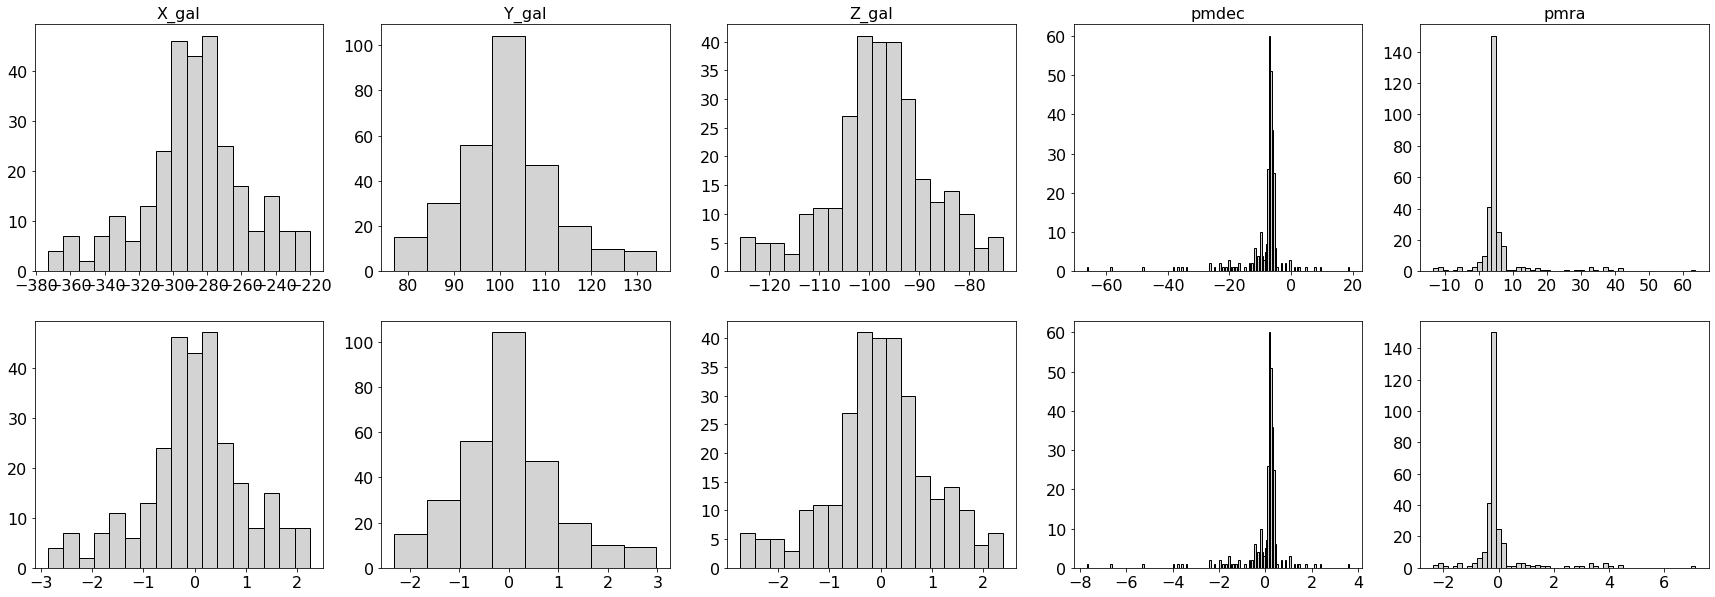

PDF saved as: test_scl_standard.pdf


In [9]:
# Data Scaling =========================================
if step_4:
    data_clustering = Cluster()
    data_clustering.load_gaia_obj(sample_gaia, scl_features = ['X_gal', 'Y_gal', 'Z_gal', 'pmdec', 'pmra'], scaler = 'standard')

## 5.2 Apply HDSBCAN
After scaling the data PanGaia applies the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/#) algorithm to identify clusters within the analised dataset. The main *hyperparameters* of HDBSCAN are the *minimum Cluster Size* and the *minimum samples*. The algorithm is executed  through a range of minimum Cluster Size values to show the HDSBCAN behavior for different values of this hyperparameter. By default, the user will be asked to input the minimum samples value and a probability thresold. The identified clusters will only contain sources whose membership probability is higher than this thresold. Both the probability threshold and the minimum samples  can be set by changing line 2 below to e.g.  ```data_clustering.run_multi_hdbscan(probability = 0.8, min_samples = 1)```. The amount of clusters found and their size will be printed for each execution of the algorithm. Finally, a color-coded bar chart presenting the amount of clusters and their size as a function of minimum Cluster Size will be displayed.


Running HDBSCAN for mCls = 10:70 in steps of 1

Probability thresold set to:   80%
minSamples set to:               1

mCls = 10; clusters = 2; N_members = [191, 10]
mCls = 11; clusters = 2; N_members = [156, 18]
mCls = 12; clusters = 2; N_members = [156, 18]
mCls = 13; clusters = 2; N_members = [156, 18]
mCls = 14; clusters = 2; N_members = [156, 18]
mCls = 15; clusters = 2; N_members = [156, 18]
mCls = 16; clusters = 2; N_members = [156, 18]
mCls = 17; clusters = 2; N_members = [156, 18]
mCls = 18; clusters = 2; N_members = [156, 18]
mCls = 19; clusters = 2; N_members = [73, 30]
mCls = 20; clusters = 2; N_members = [73, 30]
mCls = 21; clusters = 2; N_members = [73, 31]
mCls = 22; clusters = 2; N_members = [60, 52]
mCls = 23; clusters = 2; N_members = [60, 52]
mCls = 24; clusters = 2; N_members = [60, 52]
mCls = 25; clusters = 2; N_members = [73, 60]
mCls = 26; clusters = 2; N_members = [73, 60]
mCls = 27; clusters = 2; N_members = [73, 60]
mCls = 28; clusters = 2; N_members = [73, 6

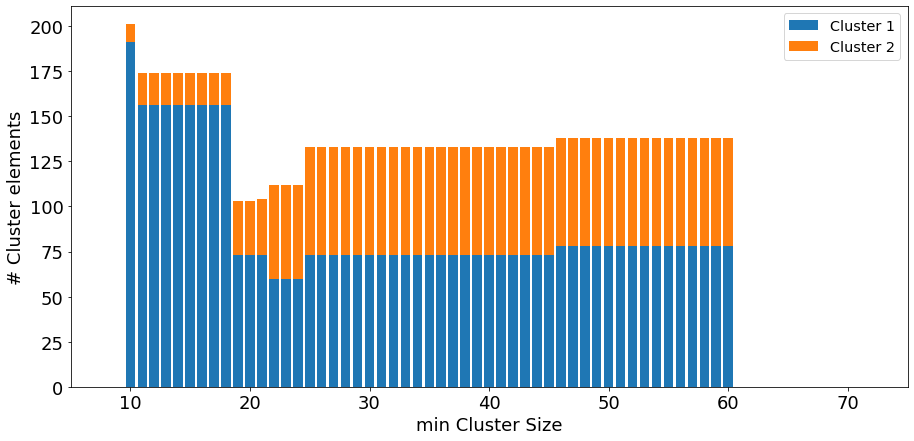

PDF saved as: test_hdb_minsamp_1_prob_0.8.pdf


In [10]:
# Apply HDSBCAN ========================================
if step_4:
#     data_clustering.run_multi_hdbscan(probability = None, min_samples = -1)
    data_clustering.run_multi_hdbscan(probability = 0.8, min_samples = 1)
    data_clustering.plot_multi_hdbscan_stats()

## 5.3 Examine the HDBSCAN outcomes
The number and sizes of the clusters found by HDSBCAN depend on the properties of the analysed dataset as well as the *minimum Cluster Size* and *minimum samples* hyperparameters, as illustrated by the bar chart diagram displayed above. The next cell allows to examine the individual outputs of HDBSCAn as a function of the minimum Cluster Size. We recommend to examine the different algorithm outcomes before proceeding to the next cell.

Insert min_Cluster_size: 15
mCls = 15; clusters = 2; N_members = [156, 18]




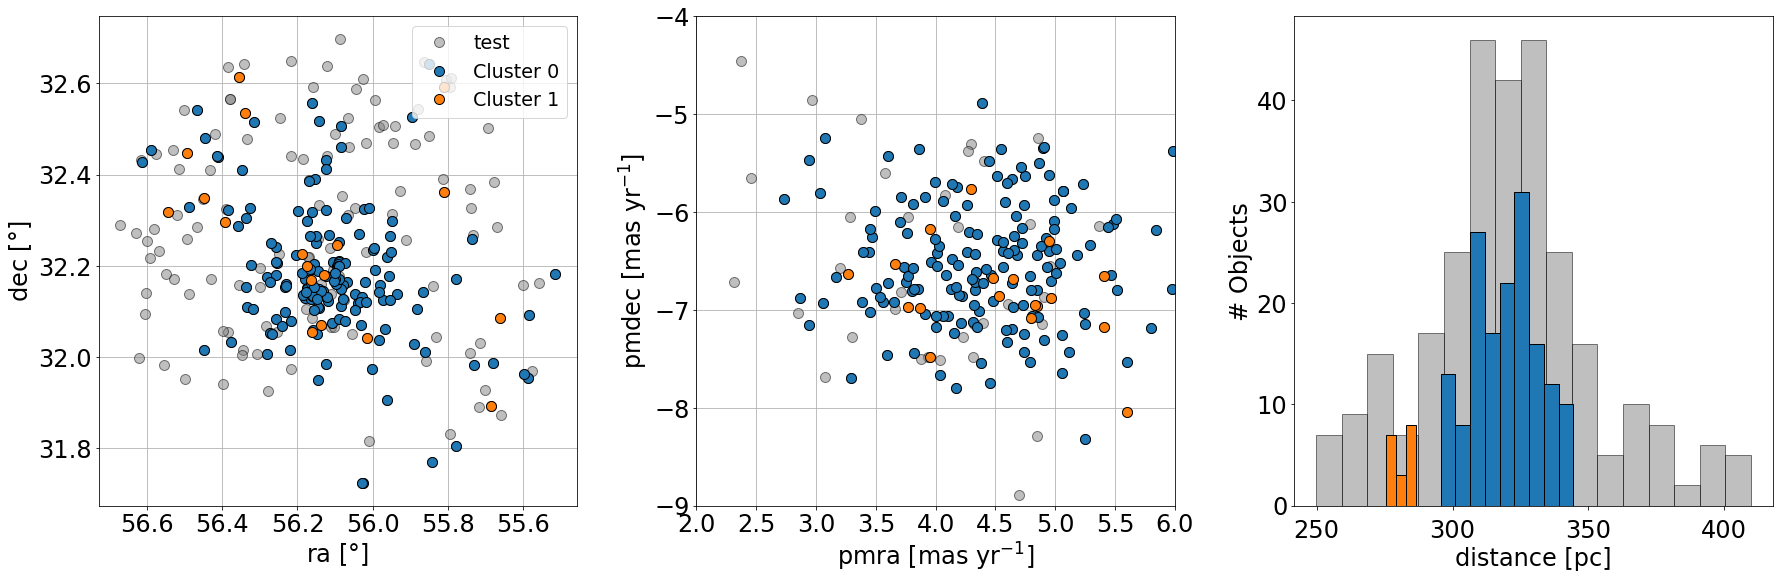

In [11]:
# Show selected HDBSCAN results ========================
if step_4:
    data_clustering.run_hdbscan(probability = data_clustering.probability, min_samples=data_clustering.min_samples, verbose = True)
    data_clustering.plot_clusters()

    if step_2:
        data_clustering.send_to_ESASky(esasky, radius = sample_gaia.ADQL['radii'].value)

# 6.- Compare to Control Sample

If ```step_1 = True``` and ```step_4 = True``` the cell below will compare the control sample to the previously selected output of HDBSCAN.

In [12]:
# Cluster Comparison ===================================
if step_1 and step_4:
    comp = Compare()
    comp.read_control(control, mew = 2)
    comp.read_clusters(data_clustering, verbose = False)
    comp.compare_to_control(verbose = True)
    print()
    comp.plot_clusters_comp(markersize = 16, fig_nm = 'default', fontsize = 20)    

Comparing HDBSCAN clusters to Control Sample:
Cluster 0 contains   156 Elements,                     including 116 (80.6%) of the Control Sample
Cluster 1 contains    18 Elements,                     including 7 ( 4.9%) of the Control Sample



AttributeError: 'LibPlotters' object has no attribute 'load_gaia_cat'

# Save HDBSCAN Output

In [ ]:
# # MERGE THIS CELL WITH PREVIOUS ONE AND SAVE THEM ALL.
# if step_4:
#     data_clustering.save_cluster()

This notebook was written by Héctor Cánovas (hcanovas@sciops.esa.int), and is licensed under a MIT License